In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import FunctionCollection as fc
fc = importlib.reload(fc)
import os
import sqlite3
import torch
%matplotlib notebook

In [3]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'OscNext_AngleO_m17'

args = {'N_edge_feats': 6,
        'N_dom_feats': 7,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 2,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': '31v5',#wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'output_offset': [3.14,1.57],
        'lr': 0.0209,
        'filename': 'dev_level7_mu_e_tau_oscweight_newfeats_unscaled.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z',
        'targets': 'event_no, azimuth, zenith, pid, energy_log10, azimuth_retro, zenith_retro, azimuth_sigma, zenith_sigma',
        'TrTV': (0,1,1)
       }

In [4]:
with sqlite3.connect(r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\Nu_lvl7_1Mio_unscaled_SRT.db") as con:
    query = "SELECT event_no FROM truth"
    old_event_nos = pd.read_sql(query,con)

with sqlite3.connect(r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\dev_level7_mu_e_tau_oscweight_newfeats_unscaled.db") as con:
    query = "SELECT event_no FROM truth"
    event_nos = pd.read_sql(query,con)

ind = event_nos.isin(old_event_nos.values)
event_nos = event_nos[(~ind).values].sample(1000000).values.reshape(-1)

In [5]:
filepath = os.path.join(path,'raw_data')

centers = pd.DataFrame({'charge_log10': [-0.033858],
                        'dom_time': [10700.0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'width': [4.5],
                        'rqe': [1.175]})
scalers = pd.DataFrame({'charge_log10': [0.274158],
                        'dom_time': [2699.0],
                        'dom_x': [300],
                        'dom_y': [300],
                        'dom_z': [300],
                        'width': [3.5],
                        'rqe': [0.175]})
centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

def y_transform(df):
    return torch.tensor(df.values)

from typing import List
@torch.jit.script
def batch_transform(x,events: List[int]):
    tmp_x = x.unsqueeze(1) - x
    cart = tmp_x[:,:,-3:]
    
    rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
    rho_mask = rho.squeeze() != 0
    if rho_mask.sum() != 0:
        cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
    tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)
    return torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0],x],dim=1)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
                               event_nos = event_nos,
                               x_transform = x_transform,
                               y_transform = y_transform,
                               batch_transform = batch_transform,
                               shuffle = False)

In [66]:
N_background = 1000
N_test = 2

device = torch.device('cpu')

In [67]:
background = dataset.collate(dataset[[_ for _ in range(N_background)]]).to(device)
test = dataset.collate(dataset[[_ for _ in range(N_background, N_background + N_test)]]).to(device)
# test.x.requires_grad_();
# test.x.requires_grad_()
# background.shape = background.x.shape
# test.shape = test.x.shape

In [68]:
import Model_Loaders.Model_17 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [69]:
from torch_scatter import scatter_sum, scatter_mean

def num_deriv(model, data, col, eps = 0.001):
    h = torch.zeros_like(data.x)
    h[:,col] += eps
    
    xph = data.clone()
    xph.x += h
    
    xmh = data.clone()
    xmh.x -= h
    
    f_xph = model(xph)
    f_xmh = model(xmh)
    return ((f_xph - f_xmh)/(2*eps)).cpu().detach()

a = num_deriv(model, test, 3, eps = 0.001)

In [70]:
def influence(model, data, col, eps = 0.001):
    derivs = num_deriv(model, data, col, eps)
    derivs = derivs.abs().mean(0)
    fig, ax = plt.subplots()
    ax.plot(derivs.numpy(),'xk')

N = 1024

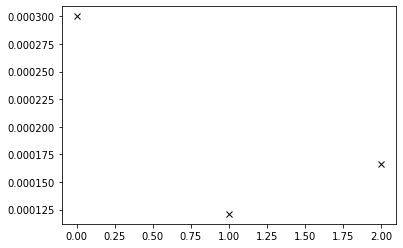

In [73]:
test = dataset.collate(dataset[np.random.choice(dataset.__len__(),N).tolist()]).to(device)
influence(model, test, 3, eps = 0.001)

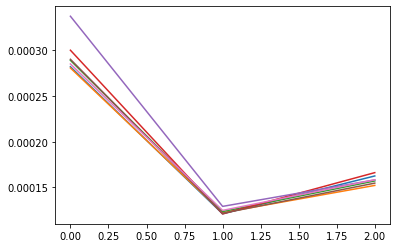

In [82]:
fig, ax = plt.subplots()
for i in range(args['N_dom_feats']):
    derivs = num_deriv(model, test, i, 0.001)
    derivs = derivs.abs().mean(0)
    
    ax.plot(derivs.numpy(),label=args['features'].split(', ')[i])
    

In [148]:
derivs = num_deriv(model, test, 3, 0.05)

(-0.0001, 0.0001)

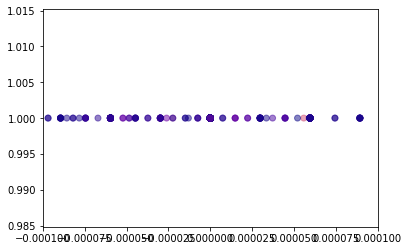

In [125]:
fig, ax = plt.subplots()
ax.scatter(derivs[:,0],np.ones(N),c = scatter_sum(test.x[:,3],test.batch), cmap='plasma',alpha=0.5)
ax.set_xlim(-0.0001,0.0001)

<IPython.core.display.Javascript object>


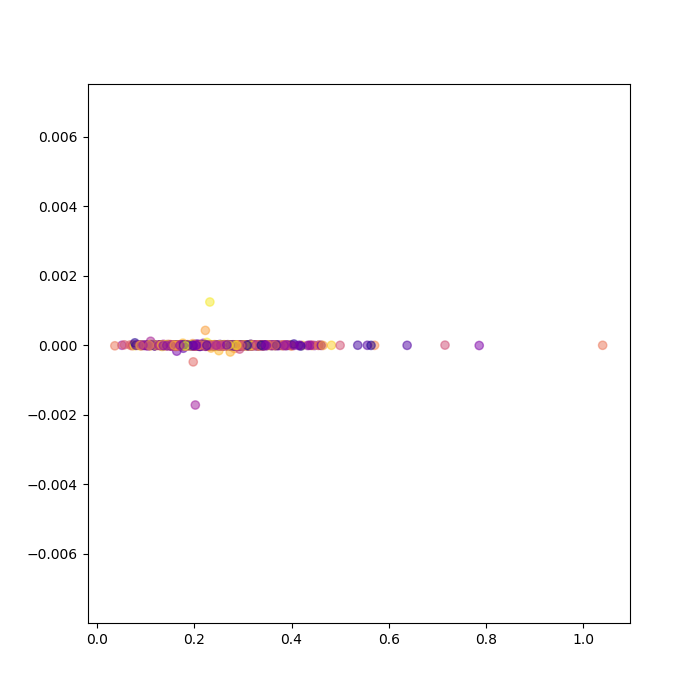

In [149]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(scatter_mean(test.x[:,3],test.batch), derivs[:,0],c = test.y.view(-1,len(args['targets'].split(', ')))[:,1], cmap='plasma',alpha=0.5)
# ax.set_xlim(-0.0001,0.0001)

In [150]:
derivs1 = num_deriv(model, test, 3, 0.01)
derivs2 = num_deriv(model, test, 3, 0.001)

In [153]:
derivs

tensor([[ 5.9605e-07, -3.2783e-06,  2.3842e-06],
        [ 1.1921e-06,  5.9605e-07,  8.3447e-06],
        [ 4.7684e-06,  0.0000e+00,  4.7684e-06],
        ...,
        [-2.9802e-07,  1.1921e-06, -2.3842e-06],
        [ 9.5367e-06, -3.5763e-06,  0.0000e+00],
        [ 2.3842e-06,  0.0000e+00, -4.7684e-06]])

<IPython.core.display.Javascript object>


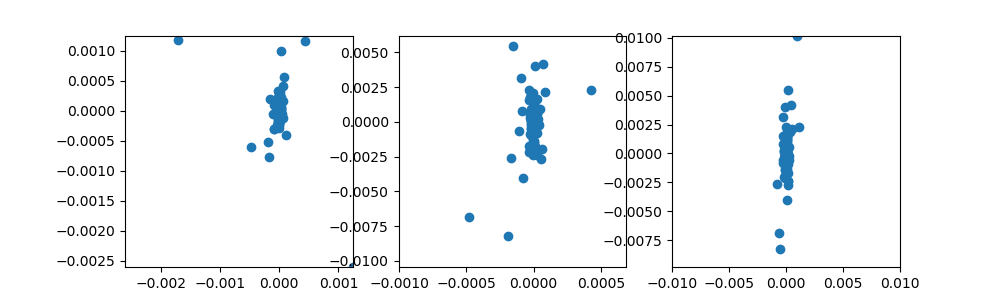

In [157]:
fig, ax = plt.subplots(ncols=3,figsize=(10,3))
ax[0].scatter(derivs[:,0],derivs1[:,0])
ax[0].set_xlim(min(derivs[:,0].min(),derivs1[:,0].min()),max(derivs[:,0].max(),derivs1[:,0].max()))
ax[0].set_ylim(min(derivs[:,0].min(),derivs1[:,0].min()),max(derivs[:,0].max(),derivs1[:,0].max()))
ax[1].scatter(derivs[:,0],derivs2[:,0])
ax[2].scatter(derivs1[:,0],derivs2[:,0])

In [131]:
import shap
# e = shap.DeepExplainer(model, background)

In [238]:
e.supports_model(model)

False

In [239]:
import torch
from torch.autograd import grad

torch.autograd.set_detect_anomaly(False)

def influence(model, src, *args):
    x = src.x.clone()#.requires_grad_()
    src.x = x
    out = model(src, *args).sum(dim=-1)
    
    influences = []
    for j in range(x.size(0)):
        print(j,out[j],grad([out[j]], [x], retain_graph=True, allow_unused=True))
#         influence = grad([out[j]], [x], retain_graph=True, allow_unused=True)[0].abs().sum(dim=-1)
#         influences.append(influence / influence.sum())

    return torch.stack(influences, dim=0)

In [240]:
a = influence(model,test)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [384, 3]], which is output 0 of SubBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [161]:
help(grad)

Help on function grad in module torch.autograd:

grad(outputs: Union[torch.Tensor, Sequence[torch.Tensor]], inputs: Union[torch.Tensor, Sequence[torch.Tensor]], grad_outputs: Union[torch.Tensor, Sequence[torch.Tensor], NoneType] = None, retain_graph: Union[bool, NoneType] = None, create_graph: bool = False, only_inputs: bool = True, allow_unused: bool = False) -> Tuple[torch.Tensor, ...]
    Computes and returns the sum of gradients of outputs w.r.t. the inputs.
    
    ``grad_outputs`` should be a sequence of length matching ``output``
    containing the "vector" in Jacobian-vector product, usually the pre-computed
    gradients w.r.t. each of the outputs. If an output doesn't require_grad,
    then the gradient can be ``None``).
    
    If ``only_inputs`` is ``True``, the function will only return a list of gradients
    w.r.t the specified inputs. If it's ``False``, then gradient w.r.t. all remaining
    leaves will still be computed, and will be accumulated into their ``.grad``
 

In [192]:
with torch.autograd.set_detect_anomaly(True):
    out = model(test)
    grad(outputs = out.sum(-1).sum(), inputs = test.x)

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [285, 3]], which is output 0 of SubBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [182]:
test.x.shape

torch.Size([285, 7])